In [1]:
import numpy as np
import pandas as pd 
import hvplot as hv
import hvplot.pandas
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))  # parent of notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

print(sys.path)  # sanity check

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

print(sys.path)

from src.util.model import eval_model, prep_data
seed = 42

from sklego.meta import OrdinalClassifier

['/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/nickclouse/Desktop/senior-proj/SPvenv/lib/python3.10/site-packages', '/Users/nickclouse/Desktop/senior-proj/avy-forecasting']
['/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/nickclouse/Desktop/senior-proj/SPvenv/lib/python3.10/site-packages', '/Users/nickclouse/Desktop/senior-proj/avy-forecasting']


In [2]:
dff0 = pd.DataFrame()

data_fp = "../../data/training_data"
for fn in os.listdir(data_fp):
    df = pd.read_csv(os.path.join(data_fp, fn))
    print(f"{fn} {df.shape}")
    if fn.split(".")[0][-1] == "1":
        continue
    else:
        dff0 = pd.concat([dff0, df])
print(dff0.shape)

danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])
danger_levels = danger_levels[danger_levels['forecast_zone_id'] == "whitefish"]
danger_levels = danger_levels[danger_levels['lower'] > -1]
danger_levels = danger_levels[['date','lower']]
danger_levels = danger_levels.drop_duplicates()
print(danger_levels.shape)
print(danger_levels.head())

X, y = prep_data(
    dff0, 
    danger_levels, 
    "lower", 
    replace_missing=True, 
    change_danger=True, 
    exclude_cols=['date','id','slope_azi', 'danger_level','altitude']) 

snow_2020-2025_p160_fxx1.csv (35016, 68)
snow_2020-2025_p160_fxx0.csv (29184, 68)
snow_2020-2025_p159_fxx0.csv (29184, 68)
snow_2020-2025_p159_fxx1.csv (35016, 68)
(58368, 68)
(802, 2)
         date  lower
20 2020-10-19      0
21 2020-10-20      0
22 2020-10-21      0
23 2020-10-22      0
24 2020-10-23      0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)

In [4]:
rf = RandomForestClassifier(random_state=seed, 
                            n_estimators=100, 
                            max_depth=50, 
                            class_weight="balanced",
                            min_samples_split=10,
                            min_samples_leaf=2)
oc = OrdinalClassifier(rf, n_jobs=-1)
oc.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,n_jobs,-1
,use_calibration,False
,calibration_kwargs,None
,n_estimators,100
,criterion,'gini'
,max_depth,50
,min_samples_split,10
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'


/Users/nickclouse/Desktop/senior-proj/SPvenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OrdinalClassifier was fitted with feature names
  warnings.warn(
/Users/nickclouse/Desktop/senior-proj/SPvenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OrdinalClassifier was fitted with feature names
  warnings.warn(


Train
Accuracy 0.90
MSE: 0.11051693404634581
RMSE: 0.33244087300803704
MAE: 0.10338680926916222
Test
Accuracy 0.60
MSE: 0.5726141078838174
RMSE: 0.7567126983762182
MAE: 0.45643153526970953


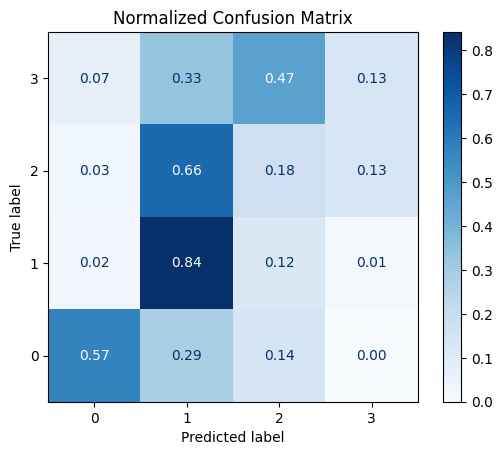

In [8]:
y_pred = oc.predict(X_test)

print("Train")
eval_model(y_train, oc.predict(X_train))

print("Test")
eval_model(y_test, y_pred, plot=True, norm=True)